## Imports

In [2]:
import xarray as xr
import numpy as np

## Means of quadratic quantities

**Problem:** We have 2 time-varying scalar fields $U(t)$ and $V(t)$. 
We want to calculate the time-averages of all the quadratic combinations of these fields, i.e. $<U^2>_t$, $<V^2>_t$, and $<UV>_t$ all simultaneously.

If these fields are chunked along time, then computing the mean of any one quadratic field should process only require loading one time chunk at a time.

(From https://github.com/pangeo-data/distributed-array-examples/issues/2)

However this simple operation has poor memory performance with dask.

### Using cubed

With cubed we can try the same problem, but state the maximum memory we will allow the computation to consume.

In this case we expect the maximum memory to be the 5x a single chunk, for the 5 fields $U$,$V$, $U^2$, $V^2$, & $UV$. We also add an additional factor x4 for the [4x overhead that cubed's blockwise operation assumes](https://github.com/tomwhite/cubed/issues/160#issuecomment-1533648472).

For a ~150MB chunk, that gives 5x4x150MB = 3GB RAM required.

In [3]:
import cubed
import cubed.random

In [4]:
spec = cubed.Spec(work_dir="tmp", max_mem=3_000_000_000)

In [5]:
U = xr.DataArray(
    name='U',
    data=cubed.random.random((5000, 1, 987, 1920), chunks=(10, 1, -1, -1), spec=spec),
    dims=["time", "face", "j", "i"],
)
V = xr.DataArray(
    name='V',
    data=cubed.random.random((5000, 1, 987, 1920), chunks=(10, 1, -1, -1), spec=spec),
    dims=["time", "face", "j", "i"], 
)
ds = xr.merge([U, V])
ds

<xarray.Dataset>
Dimensions:  (time: 5000, face: 1, j: 987, i: 1920)
Dimensions without coordinates: time, face, j, i
Data variables:
    U        (time, face, j, i) float64 ...
    V        (time, face, j, i) float64 ...

In [6]:
quad = ds**2
quad["UV"] = ds.U * ds.V
mean = quad.mean("time", skipna=False)  # skipna=False to avoid eager load, see xarray issue #7243

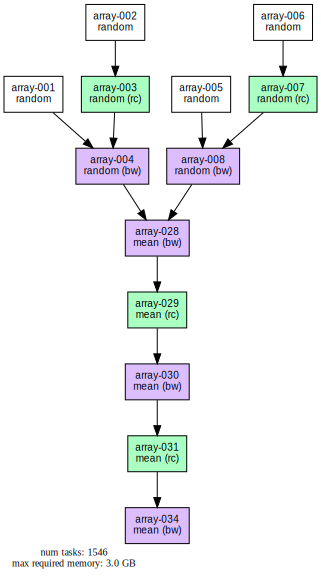

In [7]:
mean['UV'].data.visualize()

In [8]:
print(ds.nbytes / 1e9)
print(mean.nbytes / 1e9)

151.6032
0.04548096


So we are hoping to generate and process 151GB of random data using this laptop (which has only 32GB of RAM) and load a reduced result that is just 45MB in size.

In [9]:
from cubed.extensions.tqdm import TqdmProgressBar
from cubed.extensions.history import HistoryCallback

## Cubed on lithops

In [10]:
import logging
from tqdm.contrib.logging import logging_redirect_tqdm

logging.basicConfig(level=logging.INFO)
# turn off lithops own progress bar
logging.getLogger("lithops.wait").setLevel(logging.WARNING)
# suppress harmless connection pool warnings
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)

LITHOPS_LOCAL_CONFIG = {"lithops": {"backend": "localhost", "storage": "localhost"}}

In [11]:
from cubed.runtime.executors.lithops import LithopsDagExecutor

executor = LithopsDagExecutor(config=LITHOPS_LOCAL_CONFIG)

Run a trivial job to measure the "reserved" memory (memory that is used by the runtime for everything except array allocations).

In [17]:
reserved_mem = cubed.measure_reserved_memory(executor) * 1.05  # add some wiggle room
reserved_mem

INFO:lithops.config:Lithops v2.9.0
INFO:lithops.storage.backends.localhost.localhost:Localhost storage client created
INFO:lithops.localhost.localhost:Localhost compute client created
INFO:lithops.invokers:ExecutorID ecb046-1 | JobID M000 - Selected Runtime: python 
INFO:lithops.invokers:ExecutorID ecb046-1 | JobID M000 - Starting function invocation: <lambda>() - Total: 1 activations
INFO:lithops.invokers:ExecutorID ecb046-1 | JobID M000 - View execution logs at /private/var/folders/9j/h1v35g4166z6zt816fq7wymc0000gn/T/lithops-tom/logs/ecb046-1-M000.log


38397542.4

That's about 38MB of reserved memory.

In [12]:
%%time
with logging_redirect_tqdm():
    progress = TqdmProgressBar()
    hist = HistoryCallback()
    mean.compute(
        executor=executor,
        callbacks=[progress, hist],
    )

array-003:   0%|          | 0/1 [00:00<?, ?it/s]

array-007:   0%|          | 0/1 [00:00<?, ?it/s]

array-004:   0%|          | 0/500 [00:00<?, ?it/s]

array-008:   0%|          | 0/500 [00:00<?, ?it/s]

array-014:   0%|          | 0/500 [00:00<?, ?it/s]

array-021:   0%|          | 0/500 [00:00<?, ?it/s]

array-028:   0%|          | 0/500 [00:00<?, ?it/s]

array-015:   0%|          | 0/21 [00:00<?, ?it/s]

array-022:   0%|          | 0/21 [00:00<?, ?it/s]

array-029:   0%|          | 0/21 [00:00<?, ?it/s]

array-016:   0%|          | 0/21 [00:00<?, ?it/s]

array-023:   0%|          | 0/21 [00:00<?, ?it/s]

array-030:   0%|          | 0/21 [00:00<?, ?it/s]

array-017:   0%|          | 0/1 [00:00<?, ?it/s]

array-024:   0%|          | 0/1 [00:00<?, ?it/s]

array-031:   0%|          | 0/1 [00:00<?, ?it/s]

array-020:   0%|          | 0/1 [00:00<?, ?it/s]

array-027:   0%|          | 0/1 [00:00<?, ?it/s]

array-034:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:lithops.config:Lithops v2.9.0
INFO:lithops.storage.backends.localhost.localhost:Localhost storage client created
INFO:lithops.localhost.localhost:Localhost compute client created
INFO:lithops.invokers:ExecutorID ecb046-0 | JobID M000 - Selected Runtime: python 
INFO:lithops.invokers:Runtime python is not yet deployed
INFO:lithops.localhost.localhost:Deploying runtime: python
INFO:lithops.invokers:ExecutorID ecb046-0 | JobID M000 - Starting function invocation: <lambda>() - Total: 1 activations
INFO:lithops.invokers:ExecutorID ecb046-0 | JobID M000 - View execution logs at /private/var/folders/9j/h1v35g4166z6zt816fq7wymc0000gn/T/lithops-tom/logs/ecb046-0-M000.log
INFO:lithops.invokers:ExecutorID ecb046-0 | JobID M001 - Selected Runtime: python 
INFO:lithops.invokers:ExecutorID ecb046-0 | JobID M001 - Starting function invocation: <lambda>() - Total: 1 activations
INFO:lithops.invokers:ExecutorID ecb046-0 | JobID M001 - View execution logs at /private/var/folders/9j/h1v35g4166z6zt81

CPU times: user 1min 9s, sys: 44.1 s, total: 1min 53s
Wall time: 8min 20s


Let's analyse the actual memory usage, and compare it to what Cubed predicted.

In [15]:
import pandas as pd

In [19]:
plan_df = pd.read_csv("history/plan-1683714855.csv")
stats_df = pd.read_csv("history/stats-1683714855.csv")

reserved_mem_mb = reserved_mem / 1_000_000

# convert memory to MB
plan_df["required_mem_mb"] = plan_df["required_mem"] / 1_000_000
plan_df["total_mem_mb"] = plan_df["required_mem_mb"] + reserved_mem_mb
plan_df = plan_df[
    ["array_name", "op_name", "required_mem_mb", "total_mem_mb", "num_tasks"]
]
stats_df["peak_mem_start_mb"] = stats_df["peak_memory_start"] / 1_000_000
stats_df["peak_mem_end_mb"] = stats_df["peak_memory_end"] / 1_000_000
stats_df["peak_mem_delta_mb"] = (
    stats_df["peak_mem_end_mb"] - stats_df["peak_mem_start_mb"]
)

# find per-array stats
df = stats_df.groupby("array_name", as_index=False).agg(
    {
        "peak_mem_start_mb": ["min", "mean", "max"],
        "peak_mem_end_mb": ["max"],
        "peak_mem_delta_mb": ["min", "mean", "max"],
    }
)

# flatten multi-index
df.columns = ["_".join(a).rstrip("_") for a in df.columns.to_flat_index()]
df = df.merge(plan_df, on="array_name")

def utilization(row):
    return row["peak_mem_end_mb_max"] / row["total_mem_mb"]

df["utilization"] = df.apply(lambda row: utilization(row), axis=1)
df = df[
    [
        "array_name",
        "op_name",
        "num_tasks",
        "peak_mem_start_mb_max",
        "peak_mem_end_mb_max",
        "peak_mem_delta_mb_max",
        "required_mem_mb",
        "total_mem_mb",
        "utilization",
    ]
]

df

,array_name,op_name,num_tasks,peak_mem_start_mb_max,peak_mem_end_mb_max,peak_mem_delta_mb_max,required_mem_mb,total_mem_mb,utilization
0,array-003,rechunk,1,4.452352,37.765120,33.312768,3000.000000,3038.397542,0.012429
1,array-004,blockwise,500,6.496256,457.232384,450.994176,606.412808,644.810350,0.709096
2,array-007,rechunk,1,4.493312,36.638720,32.145408,3000.000000,3038.397542,0.012059
3,array-008,blockwise,500,6.512640,457.265152,451.002368,606.412808,644.810350,0.709147
4,array-014,blockwise,500,6.590464,490.696704,484.458496,606.412816,644.810358,0.760994
5,array-015,rechunk,21,7.307264,2153.578496,2147.311616,3000.000000,3038.397542,0.708788
6,array-016,blockwise,21,7.331840,1650.053120,1643.761664,1516.032000,1554.429542,1.061517
7,array-017,rechunk,1,4.546560,1415.245824,1410.699264,3000.000000,3038.397542,0.465787
8,array-020,blockwise,1,4.673536,942.239744,937.566208,1334.108160,1372.505702,0.686511
9,array-021,blockwise,500,6.565888,490.618880,484.315136,606.412816,644.810358,0.760873


The "utilization" column shows the actual peak memory used in any task when computing a particular array as a proportion of the total memory available (reserved + max).

This should always be less than 1. In a few cases we exceeded 1 by a small margin - these are worth looking into, so Cubed makes better predictions in the future.

The "peak_mem_end_mb_max" is the actual maximum memory used at any point - it's never higher than 2.2GB.